![voice2json icon](img/voice2json.svg)

Michael Hansen

September 2019

---

At a high level, voice2json transforms audio data (voice commands) into JSON events.

![Rhasspy overview](img/overview-1.svg)

The voice commands are specified beforehand in a compact, text-based format:

```
[LightState]
states = (on | off)
turn (<states>){state} [the] light
```

This format supports:

* `[optional words]`
* `(alternative | choices)`
* `rules = ...`
* `<rule references>`
* `(...){tags}`

During **training**, voice2json generates artifacts that can recognize and decode the specified voice commands. If these commands change, voice2json must be **re-trained**.

![Sentences and training](img/overview-2.svg)

## Core Components

At its core, voice2json can be broken down into **speech** and **intent** recognition components.

![Rhasspy breakdown](img/overview-3.svg)

When voice commands are recognized by the speech component, the transcription is given to the intent recognizer. The result is a structured JSON event.

## Speech to Text

The transcription of voice commands in voice2json is handled by one of two open source systems:

* Pocketsphinx
    * CMU (2000)
* Kaldi
    * Johns Hopkins (2009)
    
Both systems require:

* Acoustic model
* Pronunciation dictionary
* Language model

![Speech breakdown](img/overview-4.svg)

### Acoustic Model

An acoustic model maps **acoustic features** to likely **phonemes**. 

Typically, Mel-frequency cepstrum coefficients (**MFCCs**) are used as acoustic features.

![Acoustic model](img/overview-5.svg)

Phonemes are language (and locale) specific. They are the *indivisible units* of word pronunciation. A linguistic analysis of a language is required, and human languages typically have no more than a few dozen phonemes.

An acoustic model is a **statistical mapping** between MFCCs and (typically) singletons, pairs, and triplets of phonemes. This mapping is learned from a large collection of speech examples and their corresponding transcriptions.

### Pronunciation Dictionary

A dictionary that maps sequences of phonemes to **words** is needed both to train an acoustic model and to do speech recognition. More than one mapping (pronunciation) is possible.

For practical purposes, a word is just the "stuff between whitespace". What matters most is consistency -- i.e., compound words, contractions.

| Phoneme | Word | Pronunciation  |
| ------- | ------- | -------     |
| AA      | odd     | AA D        |
| AE      | at      | AE T        |
| AH      | hut     | HH AH T     |
| AO      | ought   | AO T        |
| AW      | cow     | K  AW       |
| AY      | hide    | HH AY D     |
| B       | be      | B  IY       |
| CH      | cheese  | CH IY Z     |
| D       | dee     | D  IY       |
| DH      | thee    | DH IY       |
| EH      | Ed      | EH D        |
| ER      | hurt    | HH ER T     |
| EY      | ate     | EY T        |
| F       | fee     | F  IY       |
| G       | green   | G  R  IY N  |
| HH      | he      | HH IY       |
| IH      | it      | IH T        |
| IY      | eat     | IY T        |
| JH      | gee     | JH IY       |
| K       | key     | K  IY       |
| L       | lee     | L  IY       |
| M       | me      | M  IY       |
| N       | knee    | N  IY       |
| NG      | ping    | P  IH NG    |
| OW      | oat     | OW T        |
| OY      | toy     | T  OY       |
| P       | pee     | P  IY       |
| R       | read    | R  IY D     |
| S       | sea     | S  IY       |
| SH      | she     | SH IY       |
| T       | tea     | T  IY       |
| TH      | theta   | TH EY T  AH |
| UH      | hood    | HH UH D     |
| UW      | two     | T  UW       |
| V       | vee     | V  IY       |
| W       | we      | W  IY       |
| Y       | yield   | Y  IY L  D  |
| Z       | zee     | Z  IY       |
| ZH      | seizure | S  IY ZH ER |

![Dictionary mapping](img/overview-6.svg)

A **grapheme to phoneme** model can be used to predict the pronunciation of words outside of the dictionary. This is a statisical model that maps sequences of characters (graphemes) to sequences of phonemes. voice2json uses a tool called Phonetisaurus for this purpose.

### Language Model

A language model is a statistical mapping of (typically) word singletons, pairs, and triplets to **probabilities**.

```
0.2  sod
0.2  sawed
0.2  that
0.2  that's
0.2  odd

0.25  that's odd
0.25  that sawed
0.25  that sod
0.25  odd that

0.5  that's odd that
0.5  that sod that
```

This mapping is derived from a large text corpus, usually books, news, Wikipedia, etc. Not all pairs/triplets will be present, so their probabilities have to be guessed by some algorithm.

![Language mapping](img/overview-7.svg)

### Sentences

The language model will only give you sentence fragments, but you can get complete "sentences" with a few tricks:

* Virtual start/stop sentence words (`<s>`, `</s>`)
* Sliding time window
* Break audio at long pauses or assume single sentence

Unfortunately, the recognized "sentences" may be non-sensical and have little to do with previous sentences:

```
that sod that that sod that sawed...
```

Modern transformer networks (~RNNs) can handle these long-term dependencies much better, but:

* Require a vast amount of training data
* Are slow/resource intensive to (re-)train

For voice2json's intended domain (pre-specified, short voice commands) the tricks above suffice for now.

## Text to Intent

The speech recognition system(s) in voice2json produce transcriptions that feed directly into the intent recognition system. Because both systems were trained together from `sentences.ini`, all valid commands (with minor variations) should be correctly translated to JSON events.

### Finite State Transducers

A finite state transducer (FST) is a formal state transition system with input/output symbols and weights. voice2json uses the [OpenFST](http://www.openfst.org) library to do FST operations.

The example below creates a three state FST with some transition arcs. A state transition occurs when the input symbol of the arc is matched, and the output symbol is emitted. The `<eps>` (epsilon) symbol is used by convention to represent a automatic transition (input) or an empty string (output).

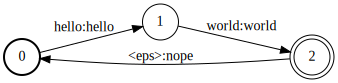

In [1]:
import pywrapfst as fst

test_fst = fst.Fst()

# Create a start state
s0 = test_fst.add_state()
test_fst.set_start(s0)

# Add two more states
s1 = test_fst.add_state()
s2 = test_fst.add_state()

# Add some arcs
weight_one = fst.Weight.One(test_fst.weight_type())
symbols = fst.SymbolTable()

eps = symbols.add_symbol("<eps>")
hello = symbols.add_symbol("hello")
world = symbols.add_symbol("world")
nope = symbols.add_symbol("nope")

test_fst.add_arc(s0, fst.Arc(hello, hello, weight_one, s1))
test_fst.add_arc(s1, fst.Arc(world, world, weight_one, s2))
test_fst.add_arc(s2, fst.Arc(eps, nope, weight_one, s0))

test_fst.set_final(s2)
test_fst.set_input_symbols(symbols)
test_fst.set_output_symbols(symbols)

# Display
test_fst

voice2json splits the contents of a `sentences.ini` into a set of [JSGF grammars](https://www.w3.org/TR/jsgf/), one per `[Intent]`. Each grammar is then transformed into an FST.

```ini
[LightState]
states = (on | off)
turn (<states>){state} [the] light
```

In [2]:
%cat data/LightState.gram

#JSGF V1.0;
grammar LightState;

public <LightState> = ((turn (<states>){state} [the] light));
<states> = ((on | off));


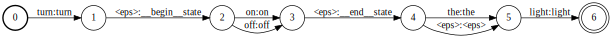

In [3]:
fst.Fst.read("data/LightState.fst")

The FST above will accept all of the sentences implicit in the `sentences.ini` file above, which are:

```
turn on the light
turn on light
turn off the light
turn off light
```

The transitions from states 1 to 2, and from states 3 to 4 are especially important. These transitions have an `<eps>` input symbol, meaning they will be taken automatically with no extra input. They will then output `__begin__state` and `__end__state` respectively. So the accepted sentences above will be transformed into the following:

| Input                | Output                                           |
| -------              | --------                                         |
| `turn on the light`  | `turn __begin__state on __end__state the light`  |
| `turn on light`      | `turn __begin__state on __end__state light`      |
| `turn off the light` | `turn __begin__state off __end__state the light` |
| `turn off light`     | `turn __begin__state off __end__state light`     |

The `__begin__` and `__end__` symbols are used by voice2json to construct the final JSON event for each sentence. They mark the beginning and end of a **tagged** block of text in the original `sentences.ini` file, specifically `(on | off){state}` here. These begin/end symbols can be easily translated into a common scheme for annotating text corpora (IOB) in order to train a Named Entity Recognizer (NER). [flair](http://github.com/zalandoresearch/flair) can read such corpora, for example, and train NERs using [PyTorch](https://pytorch.org).

#### intent.fst

voice2json takes combines all of the individual FSTs for each intent into a single FST named `intent.fst`.

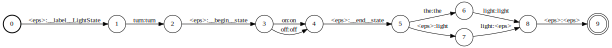

In [4]:
fst.Fst.read("data/intent.fst")

Because we only have one intent (`LightState`), this looks pretty similar to `LightState.fst`. The first `<eps>` transition, however, emits a `__label__LightState` symbol that indicates which intent the following sentences belong to. When more than one intent is present, there will be multiple `__label__` transitions from the first state.

The `__label__` notation is taken from [fasttext](https://fasttext.cc), a highly-performant sentence classification framework. voice2json could therefore be used to produce training data for a fasttext model.

### Opengrm

Thanks to the [opengrm](http://www.opengrm.org/twiki/bin/view/GRM/NGramLibrary) library, voice2json can take the `intent.fst` produced during the initial stages of training and *directly* generate a language model!

![intent to language model](img/overview-8.svg)

By going from `sentences.ini` to JSGF grammars to `intent.fst` and finally to a language model, voice2json *avoids generating all possible training sentences*. For domains with many intents, and many more ways of expressing them, this is the difference between several seconds and dozens of minutes in training time.

### fsticuffs

voice2json's OpenFST-based intent recognizer is called `fsticuffs`. It takes the `intent.fst` generated during training and uses it to convert transcriptions from the speech system to JSON events.

![speech to json](img/overview-9.svg)

This is accomplished by simply running the transcription through `intent.fst` and parsing the output. The transcription "turn on the light" is split (by whitespace) into the words `turn` `on` `the` `light`.

Following `intent.fst`, this will generate:

`__label__LightState` `turn` `__begin__state` `on` `__end__state` `the` `light`

With some simple rules for `__label__`, `__begin__`, and `__end__`, this is then transformed into:

```json
{ 
  "intent": {
    "name": "LightState"
  },
  "slots": {
    "state": "on"
  }
}
```

#### Fuzzy FSTs

What if `fsticuffs` were to receive the transcription "would you turn on the light"? This is not possible with the example `sentences.ini` file, but perhaps we want to also accept text input via chat.

Because `would` and `you` are not a valid symbols in `intent.fst`, there will be **no output** from the FST. To deal with this, voice2json allows **stop words** (common words) to be ignored during recognition. Additionally, all unknown words (not present in `sentences.ini`) can be optionally skipped by `fsticuffs`. This works well as long as sentences like "**don't** turn on the light" aren't expected to work!

### Slots

It can be cumbersome to maintain large lists of items in `sentences.ini`:

```
[SetColor]
set the color to (red | green | blue | orange | ...){color}
```

Additionally, it's not easy to programmatically modify these lists. voice2json has a simple syntax for specifying **slot files**:

```
[SetColor]
set the color to ($colors){color}
```

During training, voice2json will look for a file named `slots/colors` in the user's profile. This is simply a text file with one item per line:

```
red
green
blue
orange
...
```

voice2json interprets each line as a JSGF fragment, allowing for optional words, alternatives, etc.:

```
[(light | dark)] red
[blue] green
...
```

### Word/Tag Replacement

voice2json allows you to control how words are emitted in the final JSON event.

Consider the following example with two lights, a lamp in the living room and a light in the garage:

```
[LightState]
state = (on | off)
name = (living room lamp | garage light)
turn (<state>){state} [the] (<name>){name}
```

If the voice command "turn on the living room lamp" is spoken, voice2json will produce the expected JSON:

```json
{ 
  "intent": {
    "name": "LightState"
  },
  "slots": {
    "state": "on",
    "name": "living room lamp"
  }
}
```

If the system downstream receiving this JSON does not know what `on` and `living room lamp` are, it will be unable to handle the intent. Suppose this hypothetical system knows only how to `enable` and `disable` either `switch_1` or `switch_2`. We could ease the burden of interfacing with some minor modifications:

```
[LightState]
state = (on:enable | off:disable)
name = (living room lamp){name:switch_1} | (garage light){name:switch_2)
turn (<state>){state} [the] (<name>){name}
```

The syntax `on:enable` tells voice2json to *listen* for the word `on`, but *emit* the word `enable` in its place. Similarly, the syntax `(living room lamp){name:switch_1}` tells voice2json to listen for `living room lamp`, but actually put `switch_1` in the `name` slot:

```json
{ 
  "intent": {
    "name": "LightState"
  },
  "slots": {
    "state": "enable",
    "name": "switch_1"
  }
}
```

This syntax also works inside slot files. When nothing is put on the right side of the `:`, the word is silently dropped, so:

```
[the:] light
```

will match both `the light` and `light`, but always emit just `light`. This technique is especially useful in English with articles like "a" and "an". It is common to write something in `sentences.ini` like this:

```
[LightState]
turn on (a | an) ($colors){color} light
```

where `slots/colors` might be:

```
red
orange
```

This will match `turn on a red light` and `turn on an orange light` as intended, but also `turn on an red light` and `turn on a orange light`. Using word replacement and a slot file, we can instead write:

```
[LightState]
turn on ($colors){color} light
```

where `slots/colors` is:

```
a: red
an: orange
```

This will *only* match `turn on a red light` and `turn on an orange light` as well as ensuring that the `color` slot does not contain "a" or "an"!